In [137]:
import os
import shutil
import subprocess
import time

import gymnasium as gym
import imageio
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
from stable_baselines3 import PPO

from utils import gauss, gaussp, inv_hea, hea, porte

In [138]:
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        # Access relevant state and action variables
        
        #state
        mapping = {"z": 0, "a": 1, "a_hip": 2, "a_knee": 3, "a_ankle": 4, "v_x": 5, "v_z": 6, "a_d": 7, "a_hip_d": 8, "a_knee_d": 9, "a_ankle_d": 10}
        z = obs[0]                  # z of the robot
        a = obs[1]                  # Angle of the robot
        a_hip = obs[2]              # Angle of the hip
        a_knee = obs[3]             # Angle of the knee
        a_ankle = obs[4]            # Angle of the ankle
        v_x = obs[5]                # Velocity in x direction
        v_z = obs[6]                # Velocity in z direction
        a_d = obs[7]                # Angular velocity 
        a_hip_d = obs[8]            # Angular velocity of the hip
        a_knee_d = obs[9]           # Angular velocity of the knee
        a_ankle_d = obs[10]         # Angular velocity of the ankle
        
        #action
        torque_hip = action[0]      # Torque applied to the hip
        torque_knee = action[1]     # Torque applied to the knee
        torque_ankle = action[2]    # Torque applied to the ankle

        energy_used = np.sum(np.square(action))  # Simplistic energy calculation
      
        # Custom reward logic
        get_straight = gauss(z, 1.2, 0.5*1.2) * gauss(a, -2*np.pi, 0.5*2*np.pi) * gauss(a_hip, 0, 0.5*2*np.pi) * gauss(a_knee, 0, 0.5*2*np.pi) * gauss(a_ankle, 0, 0.5*2*np.pi)
        vel_flip = - 2 * torque_hip * a_hip + torque_knee * a_knee + torque_ankle * a_ankle

        flipping = - a_d * (1.0 + 18 * z + .6 * vel_flip - .8 * v_x) - 15 * abs(a_hip)
        landing = 5e2 * get_straight #huge reward for good landing
        
        custom_reward = 0
        custom_reward += landing
        custom_reward += flipping
        
        # attributes for monitoring
        self.vel_act = vel_flip
        self.get_straight = get_straight
        self.landing = landing
        self.flipping = flipping

        if done:
            custom_reward -= 200  # Heavy penalty for falling

        return obs, custom_reward, done, truncated, info

In [139]:
d = time.strftime("%Y-%m-%d_%H-%M-%S")

healthy_reward = 1
healthy_z_range = (0.2, float("inf"))
healthy_angle_range = (-float("inf"), float("inf"))
reset_noise_scale = 5e-3
exclude_current_positions_from_observation = True

env = gym.make('Hopper-v4', render_mode='rgb_array', healthy_reward=healthy_reward, healthy_z_range=healthy_z_range, healthy_angle_range=healthy_angle_range, reset_noise_scale=reset_noise_scale, exclude_current_positions_from_observation=exclude_current_positions_from_observation)
env = CustomRewardWrapper(env)

model = PPO("MlpPolicy", env, verbose=1)

# Train the model
n_learning_steps = 1_000_000
model.learn(total_timesteps=n_learning_steps)

# Save the model
model.save("hopper_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 177      |
|    ep_rew_mean     | 4.92e+03 |
| time/              |          |
|    fps             | 1072     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 172         |
|    ep_rew_mean          | 5.19e+03    |
| time/                   |             |
|    fps                  | 536         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006655219 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss   

Episode finished after 1000 timesteps


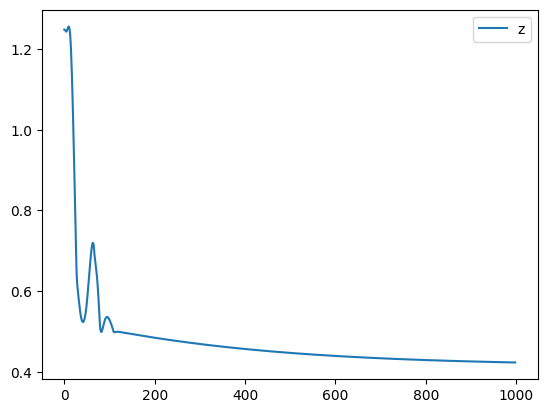

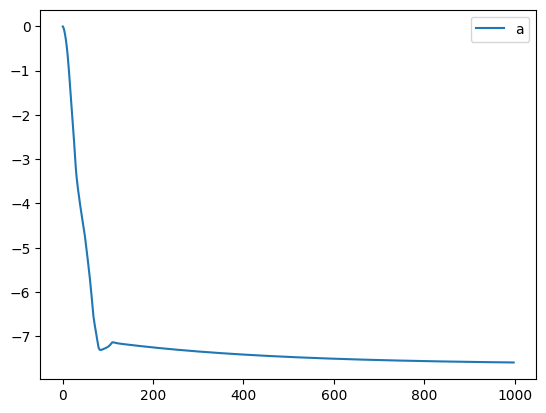

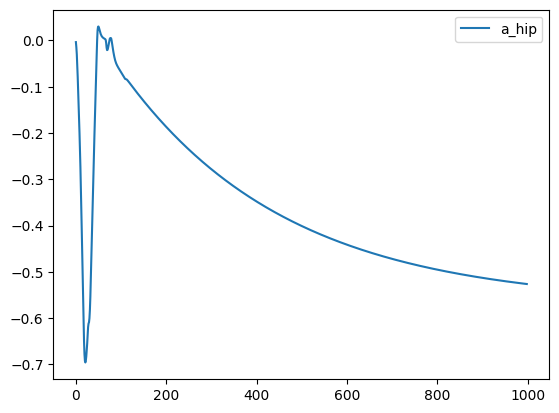

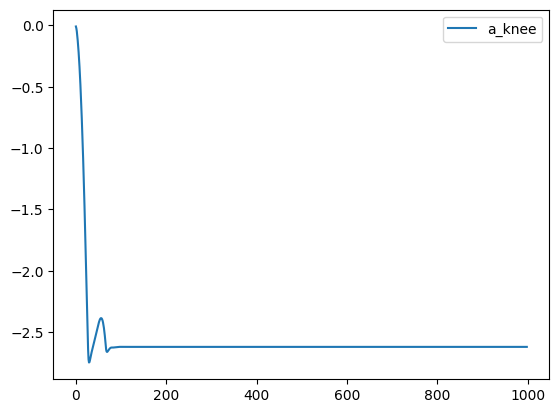

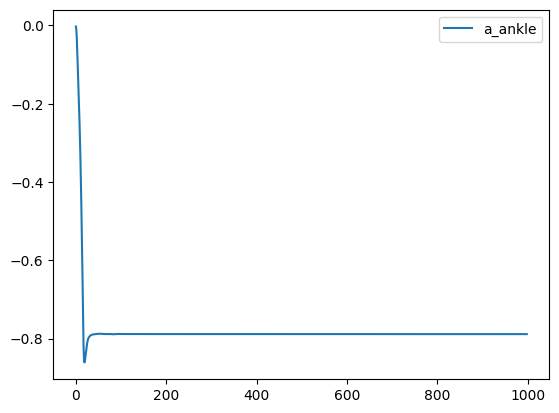

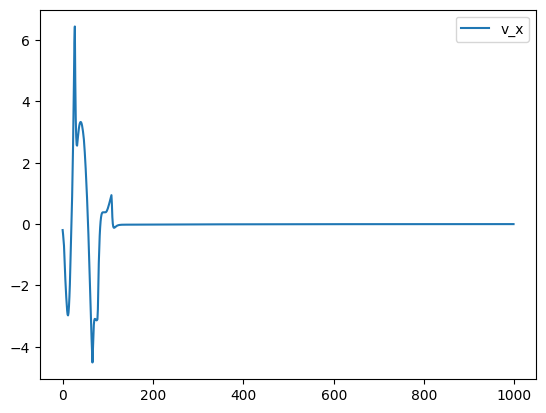

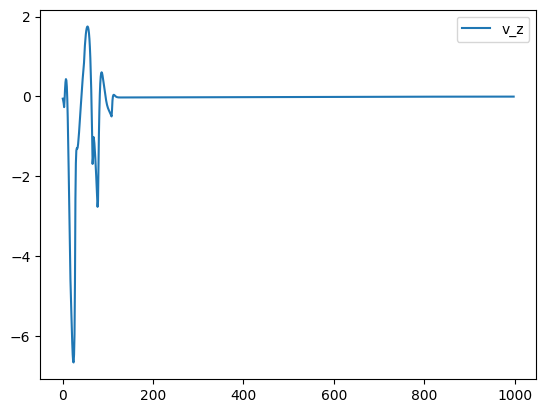

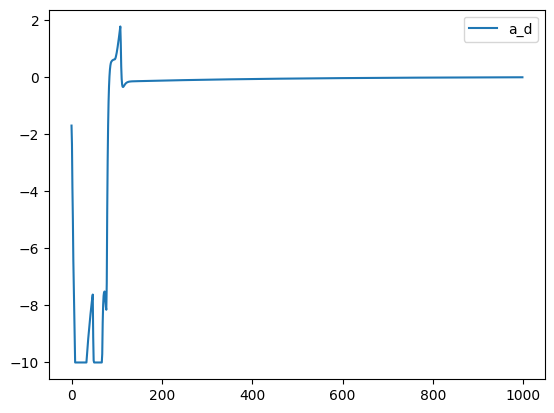

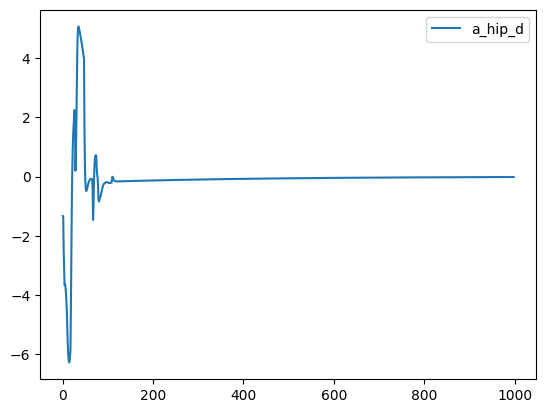

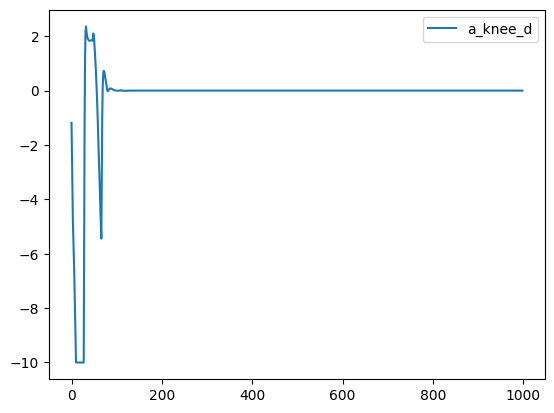

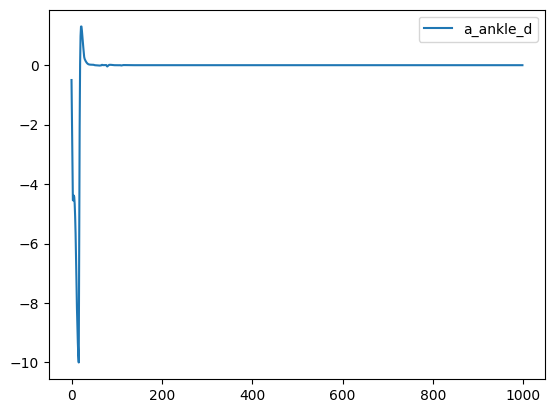

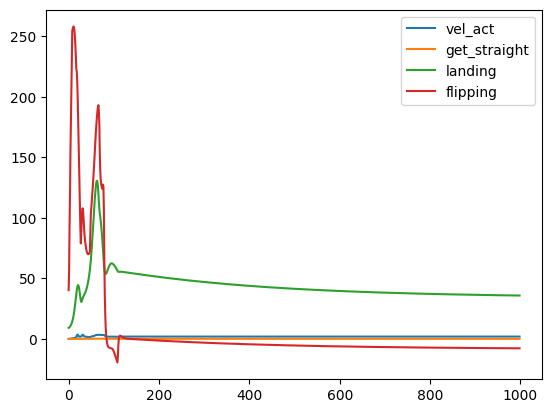

In [140]:
vec_env = model.get_env()
obs = vec_env.reset()

mapping = {"z": 0, "a": 1, "a_hip": 2, "a_knee": 3, "a_ankle": 4, "v_x": 5, "v_z": 6, "a_d": 7, "a_hip_d": 8, "a_knee_d": 9, "a_ankle_d": 10}

writer = imageio.get_writer('hopper-flip.mp4', fps=50)

N_step = 1000
s_a = np.zeros((N_step, 14)) # 11 states + 3 actions
rwd = np.zeros((N_step, 4)) # vel_act, get_straight, landing, flipping

for i in range(N_step):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    writer.append_data(vec_env.render("rgb_array"))
    s_a[i, :] = np.concatenate((obs[0], action[0]))
    rwd[i, :] = env.vel_act, env.get_straight, env.landing, env.flipping
    #VecEnv resets automatically
    if done:
      N_stop = i
      print("Episode finished after {} timesteps".format(i+1))
      break
      obs = vec_env.reset()

writer.close()

#truncate the array
s_a = s_a[:N_stop, :]
rwd = rwd[:N_stop, :]

def plot(map: str="z"):
  plt.figure(map)
  plt.plot(s_a[:, mapping[map]], label=map)
  plt.legend()
  plt.show()
%matplotlib inline

for key in mapping.keys():
  plot(key)

%matplotlib inline
plt.figure("reward")
plt.plot(rwd[:, 0], label="vel_act")
plt.plot(rwd[:, 1], label="get_straight")
plt.plot(rwd[:, 2], label="landing")
plt.plot(rwd[:, 3], label="flipping")
plt.legend()
plt.show()

In [141]:
name = d
folder = 'c:/Users/killi/Documents/code/Hopper-4-flip'

shutil.copyfile('hopper.ipynb', folder + '/Run/hopper_%s.ipynb'%(name))
shutil.copyfile('hopper-flip.mp4', folder + '/Render/hopper-flip_%s.mp4'%(name))
shutil.copyfile('hopper_model.zip', folder + '/Model/hopper_model_%s.zip'%(name))

'c:/Users/killi/Documents/code/Hopper-4-flip/Model/hopper_model_2024-08-13_12-17-22.zip'